<a href="https://colab.research.google.com/github/hurricane195/Intro-to-Deep-Learning/blob/Homework_2/HW2_P1A_Without_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem 1

AlexNet is originally proposed for 227*227 image sizes. It may be too complex for the CIFAR-10 dataset, in particular, due to the low resolution of the initial images;

**try simplifying the model to make the training faster while ensuring that the accuracy stays relatively high. Report the training loss, validation loss, and validation accuracy. Also, report the number of parameters in your modified version of AlexNet and compare it against the number of parameters in the original AlexNet architectures.**

Here is a good reference guide to AlexNet: https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guideLinks to an external site.


In [ ]:
#Building off Homework 6 Problem 2B submitted for Intro to ML
#Using modified CIFAR-10 example from 'Deep-Learning-with_PyTorch' in Chapter 8 'Using Convolutions to generalize'.
#Using modified CIFAR-10 example from 'Deep-Learning-with_PyTorch' in Chapter 7 'Telling Birds from airplanes: Learning from images'.
#Using modified Temperature example from 'Deep-Learning-with_PyTorch' in Chapter 6 'Using a neural network to fit the data'.
#Using a modided example of Dr. Tabkhi's "/ResNet11" available at https://github.com/HamedTabkhi/Intro-to-DL/blob/main/ResNet11.py
#Using a modified portion from "RAlexNet Architecture: A Complete Guide" at https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide
#Help from ChatGPT
#Help from Google Colab AI assist with Colab Pro

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import time
import datetime

In [ ]:
data_path = '../data-unversioned/p1ch7/'
CIFAR10 = datasets.CIFAR10(data_path, train = True, download = True)
#test_dataset = datasets.CIFAR10(data_path, train = False, download = True)

100%|██████████| 170498071/170498071 [00:03<00:00, 45601257.31it/s]


Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/


In [ ]:
classes = CIFAR10.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

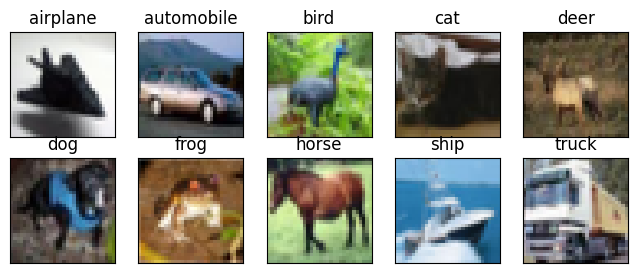

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2,5,1+i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    #ax.set_title(le.fit(class_names))
    img = next(img for img, label in CIFAR10 if label ==i)
    plt.imshow(img)
plt.show()

In [ ]:
tensor_train_dataset = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

In [ ]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [ ]:
imgs = torch.stack([img_t for img_t, _ in tensor_train_dataset], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [ ]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [ ]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [ ]:
train_dataset = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]))
test_dataset = datasets.CIFAR10(data_path, train=False, download=False,transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))]))

In [ ]:
# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(96, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)
        x = self.classifier(x)
        return x

In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Define the model and move it to the GPU if available
model = AlexNet().to(device)

In [ ]:
#count trainable parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

36925322

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Epoch [1/20], Training Loss: 2.3005, Training Accuracy: 12.86%, Validation Accuracy: 14.17%
Epoch [2/20], Training Loss: 2.1499, Training Accuracy: 20.10%, Validation Accuracy: 25.92%
Epoch [3/20], Training Loss: 1.7728, Training Accuracy: 35.16%, Validation Accuracy: 36.55%
Epoch [4/20], Training Loss: 1.5955, Training Accuracy: 41.65%, Validation Accuracy: 35.97%
Epoch [5/20], Training Loss: 1.4882, Training Accuracy: 45.75%, Validation Accuracy: 36.84%
Epoch [6/20], Training Loss: 1.3966, Training Accuracy: 49.37%, Validation Accuracy: 46.57%
Epoch [7/20], Training Loss: 1.3234, Training Accuracy: 52.23%, Validation Accuracy: 50.28%
Epoch [8/20], Training Loss: 1.2484, Training Accuracy: 55.06%, Validation Accuracy: 56.63%
Epoch [9/20], Training Loss: 1.1720, Training Accuracy: 57.98%, Validation Accuracy: 53.52%
Epoch [10/20], Training Loss: 1.0980, Training Accuracy: 60.73%, Validation Accuracy: 57.95%
Epoch [11/20], Training Loss: 1.0323, Training Accuracy: 63.33%, Validation Acc

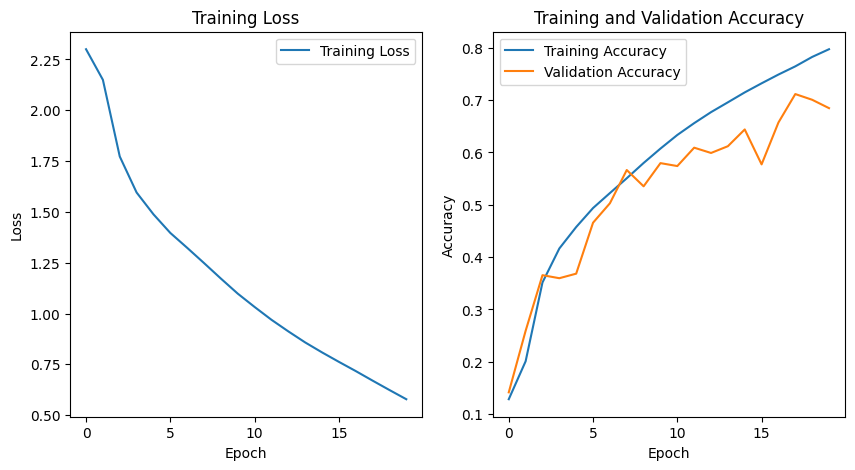

In [ ]:
start_training = time.time()

# Training the model
train_losses = []
train_accuracy = []
val_accuracy = []


# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, targets in train_loader:
         # Move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

  # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()
    main_toc = time.perf_counter()

    val_accuracy.append(correct_val / total_val)


    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_losses[-1]:.4f}, '
          f'Training Accuracy: {train_accuracy[-1]*100:.2f}%, '
          f'Validation Accuracy: {val_accuracy[-1]*100:.2f}%')

# Display training time
print('')
print('Training time:   {:.2f}s'.format(time.time() - start_training))
print('')

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Save trained model
#torch.save(model.state_dict(), 'CIFAR10_model.pth')

Precision: 0.7314292345532908
Recall: 0.6845
F1 Score: 0.678903164226967
Accuracy: 0.6845

Confusion Matrix:
[[634   2  77  14  51   3  10  12  53 144]
 [  5 348   7   6   7   1  13   6  12 595]
 [ 41   0 632  26 136  38  61  35   3  28]
 [  9   0  63 469 133 124 103  48   8  43]
 [  3   1  42  20 804  15  39  59   8   9]
 [  5   1  65 138  96 563  35  72   3  22]
 [  2   0  32  30  55   5 851   8   3  14]
 [  3   0  22  14  83  25   8 824   2  19]
 [ 31   7  21  11   8   3  10   5 762 142]
 [  4   0   5   5   4   5   3  12   4 958]]



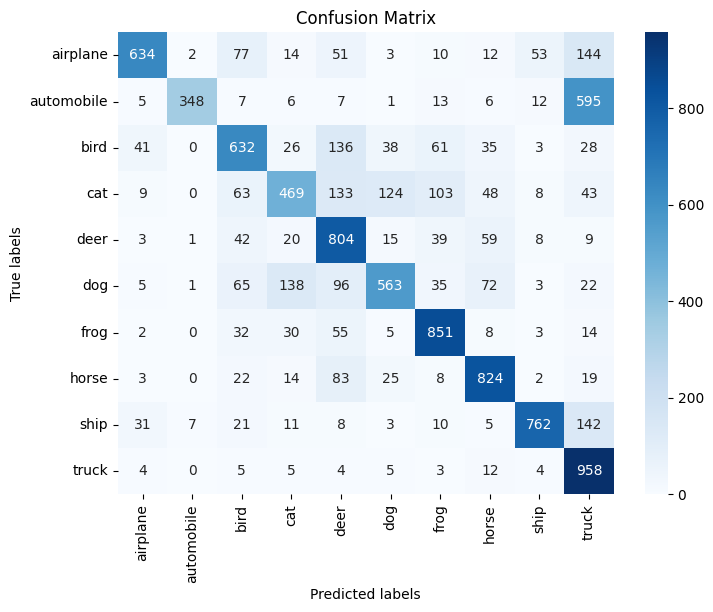

In [ ]:
# Evaluation
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())

# Calculate metrics
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)
conf_matrix = confusion_matrix(true_labels, predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)
print("")
print("Confusion Matrix:")
print(conf_matrix)
print("")

#new
# Plotting the confusion matrix with colors
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()